# PPI analysis
- As suggested, using PPI analysis to show that coupling of amg-hippocampus is higher in CS+US compared to other
- Taken from: https://dartbrains.org/content/Connectivity.html

## Here we use AR(1) model 
- In different notebook we use the OLS model as well

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import nilearn
import matplotlib.pyplot as plt
import seaborn as sns
from nltools.data import Brain_Data, Design_Matrix, Adjacency
from nltools.mask import expand_mask, roi_to_brain
from nltools.stats import zscore, fdr, one_sample_permutation
from nltools.file_reader import onsets_to_dm
from nltools.plotting import component_viewer
from scipy.stats import binom, ttest_1samp
from sklearn.metrics import pairwise_distances
from copy import deepcopy
import networkx as nx
from nilearn.plotting import plot_stat_map, view_img_on_surf
import nibabel as nib

# stats
from scipy import stats
import pingouin as pg

from nilearn import glm
from nilearn import input_data

/gpfs/ysm/project/joormann/oad4/conda_envs/naturalistic/lib/python3.7/site-packages/nilearn/datasets/__init__.py:89: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


In [2]:
output_dir = '/gpfs/gibbs/pi/levy_ifat/Or/RV_FC'

/gpfs/ysm/project/joormann/oad4/conda_envs/naturalistic/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [3]:
# get relevant subjects first
df = pd.read_csv('../scr_amg_hipp_all.csv')
subject_list = df['sub'].unique()
subject_list

array(['sub-189', 'sub-205', 'sub-071', 'sub-204', 'sub-085', 'sub-100',
       'sub-132', 'sub-185', 'sub-167', 'sub-043', 'sub-062', 'sub-073',
       'sub-082', 'sub-030', 'sub-160', 'sub-196', 'sub-1223', 'sub-169',
       'sub-1222', 'sub-055', 'sub-170', 'sub-047', 'sub-177', 'sub-130',
       'sub-172', 'sub-200', 'sub-173', 'sub-026', 'sub-059', 'sub-072',
       'sub-1232', 'sub-166', 'sub-032', 'sub-016', 'sub-1205', 'sub-186',
       'sub-056', 'sub-053', 'sub-150', 'sub-065', 'sub-154', 'sub-193',
       'sub-165', 'sub-103', 'sub-168', 'sub-102', 'sub-048', 'sub-027',
       'sub-182', 'sub-202', 'sub-203', 'sub-066', 'sub-038', 'sub-184',
       'sub-171', 'sub-179', 'sub-153', 'sub-144', 'sub-178', 'sub-063',
       'sub-010', 'sub-158', 'sub-083', 'sub-126', 'sub-152'],
      dtype=object)

In [4]:
# load timeseries (to grab amygdala ts)
sub_arr = np.load('../sub_55.npy', allow_pickle=True)
ts_arr = np.load('../array_55.npy', allow_pickle=True)

In [ ]:
# get index of subject location
idx = np.where(sub_arr=="sub-189")[0][0]
# grab that subjects amygdala ts
idx
amg = ts_arr[idx][:,20] # ROI 20 in DiFuMo is the amygdala

In [ ]:
amg.shape

In [ ]:
# grab cleaned functional and events file for each subject
# templates
func_file = '/gpfs/gibbs/pi/levy_ifat/Or/RV_FC/{sub}_ses-1_denoise_smooth6mm_task-RV_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'
events_file = '/gpfs/gibbs/pi/levy_ifat/Or/RV_FSL/eventfiles/{sub}.csv'

In [ ]:
#test on one subject

sub = 'sub-189'

func = func_file.format(sub=sub)
event = events_file.format(sub=sub)
# load data to compare later

smoothed = Brain_Data(func)

tr=2
n_tr = nib.load(func).shape[-1]

onsets = pd.read_csv(event, sep=',')
onsets.columns = ['Stim', 'Onset', 'Duration']

In [ ]:
onsets.Stim.unique()

In [ ]:
dm = onsets_to_dm(onsets, sampling_freq=1/tr, run_length=n_tr)
us_variables = ['CSplusUS1', 'CSminusUS2']
ppi_dm = dm.drop(us_variables, axis=1)
ppi_dm['US'] = pd.Series(dm.loc[:, us_variables].sum(axis=1))
ppi_dm_conv = ppi_dm.convolve()
ppi_dm_conv['amg'] = amg
ppi_dm_conv['amg_motor'] = ppi_dm_conv['amg']*ppi_dm_conv['US_c0']
dm = Design_Matrix(pd.concat([ppi_dm_conv], axis=1), sampling_freq=1/tr)
dm['intercept'] = 1
#dm = dm.add_poly(order=2, include_lower=True)

#dm.heatmap()

In [ ]:
dm

In [ ]:
smoothed.X = dm
ppi_stats = smoothed.regress(mode='ols')#, lags=0.5)
amg_US_ppi = ppi_stats['beta'][int(np.where(smoothed.X.columns=='amg_motor')[0][0])]
#amg_US_ppi.plot()
#amg_US_ppi.to_nifti()

In [ ]:
ppi_stats

In [ ]:
smoothed.data.shape
# try arma from nilearn

ar = nilearn.glm.ARModel(dm, 1)

In [ ]:
smoothed#.mask

In [ ]:
a = ar.fit(smoothed.data)

In [ ]:

masker = input_data.NiftiMasker(mask_img=smoothed.mask).fit()

In [ ]:
np.where(smoothed.X.columns=='amg_motor')[0][0]

In [ ]:
cont_fit = masker.inverse_transform(a.t(np.where(smoothed.X.columns=='amg_motor')[0][0])).to_filename('test.nii.gz')

In [ ]:
%matplotlib inline
plot_stat_map(cont_fit, threshold=2.5)

# Running PPI on the entire subjects list
- This cell was ran once, so data already there

In [5]:
# templates
func_file = '/gpfs/gibbs/pi/levy_ifat/Or/RV_FC/{sub}_ses-1_denoise_smooth6mm_task-RV_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'
events_file = '/gpfs/gibbs/pi/levy_ifat/Or/RV_FSL/eventfiles/{sub}.csv'
# run group analysis
for sub in subject_list:
    print(f'Running {sub}')
    # grab functional files
    func = func_file.format(sub=sub)
    event = events_file.format(sub=sub)
    
    # grab amygdala timeseries
    idx = np.where(sub_arr==sub)[0][0]
    # grab that subjects amygdala ts
    amg = ts_arr[idx][:,20] # ROI 20 in DiFuMo is the amygdala
    # load data to compare later
    smoothed = Brain_Data(func)
    tr=2
    n_tr = nib.load(func).shape[-1]
    onsets = pd.read_csv(event, sep=',')
    onsets.columns = ['Stim', 'Onset', 'Duration']
    dm = onsets_to_dm(onsets, sampling_freq=1/tr, run_length=n_tr)
    us_variables = ['CSplusUS1', 'CSminusUS2']
    csminus_vars = [ 'CSminus1', 'CSminus2']
    csplus_vars = ['CSplus1', 'CSplus2']
    ppi_dm = dm.drop(us_variables, axis=1)
    ppi_dm['US'] = pd.Series(dm.loc[:, us_variables].sum(axis=1))
    ppi_dm['CSm'] = pd.Series(dm.loc[:, csminus_vars].sum(axis=1))
    ppi_dm['CSp'] = pd.Series(dm.loc[:, csplus_vars].sum(axis=1))
    
    ppi_dm_conv = ppi_dm.convolve()
    ppi_dm_conv['amg'] = amg
    ppi_dm_conv['amg_US'] = ppi_dm_conv['amg']*ppi_dm_conv['US_c0']
    ppi_dm_conv['amg_CSm'] = ppi_dm_conv['amg']*ppi_dm_conv['CSm_c0']
    ppi_dm_conv['amg_CSp'] = ppi_dm_conv['amg']*ppi_dm_conv['CSp_c0']
    ppi_dm_conv['amg_USvsCSp'] = ppi_dm_conv['amg']*(ppi_dm_conv['US_c0'] - ppi_dm_conv['CSp_c0'])
    ppi_dm_conv['amg_USvsCSm'] = ppi_dm_conv['amg']*(ppi_dm_conv['US_c0'] - ppi_dm_conv['CSm_c0'])
    ppi_dm_conv['amg_USvsCS'] = ppi_dm_conv['amg']*(ppi_dm_conv['US_c0'] - (0.5*ppi_dm_conv['CSm_c0']+0.5*ppi_dm_conv['CSp_c0']))
    dm = Design_Matrix(pd.concat([ppi_dm_conv], axis=1), sampling_freq=1/tr)
    smoothed.X = dm
    # arma model using nilearn
    ar = nilearn.glm.ARModel(dm, 1)
    # fit model
    a = ar.fit(smoothed.data)
    # calling masker to turn back to beta files
    masker = input_data.NiftiMasker(mask_img=smoothed.mask).fit()
    # save relevant calculations
    masker.inverse_transform(a.t(np.where(smoothed.X.columns=='amg_US')[0][0])).to_filename(f'/gpfs/gibbs/pi/levy_ifat/Or/RV_FC/ppi/{sub}_amg_US_contrast_ppi_arma.nii.gz')
    masker.inverse_transform(a.t(np.where(smoothed.X.columns=='amg_CSm')[0][0])).to_filename(f'/gpfs/gibbs/pi/levy_ifat/Or/RV_FC/ppi/{sub}_amg_CSm_contrast_ppi_arma.nii.gz')
    masker.inverse_transform(a.t(np.where(smoothed.X.columns=='amg_CSp')[0][0])).to_filename(f'/gpfs/gibbs/pi/levy_ifat/Or/RV_FC/ppi/{sub}_amg_CSp_contrast_ppi_arma.nii.gz')
    masker.inverse_transform(a.t(np.where(smoothed.X.columns=='amg_USvsCSp')[0][0])).to_filename(f'/gpfs/gibbs/pi/levy_ifat/Or/RV_FC/ppi/{sub}_amg_USvsCSp_contrast_ppi_arma.nii.gz')
    masker.inverse_transform(a.t(np.where(smoothed.X.columns=='amg_USvsCSm')[0][0])).to_filename(f'/gpfs/gibbs/pi/levy_ifat/Or/RV_FC/ppi/{sub}_amg_USvsCSm_contrast_ppi_arma.nii.gz')
    masker.inverse_transform(a.t(np.where(smoothed.X.columns=='amg_USvsCS')[0][0])).to_filename(f'/gpfs/gibbs/pi/levy_ifat/Or/RV_FC/ppi/{sub}_amg_USvsCS_contrast_ppi_arma.nii.gz')


Running sub-189
Running sub-205
Running sub-071
Running sub-204
Running sub-085
Running sub-100
Running sub-132
Running sub-185
Running sub-167
Running sub-043
Running sub-062
Running sub-073
Running sub-082
Running sub-030
Running sub-160
Running sub-196
Running sub-1223
Running sub-169
Running sub-1222
Running sub-055
Running sub-170
Running sub-047
Running sub-177
Running sub-130
Running sub-172
Running sub-200
Running sub-173
Running sub-026
Running sub-059
Running sub-072
Running sub-1232
Running sub-166
Running sub-032
Running sub-016
Running sub-1205
Running sub-186
Running sub-056
Running sub-053
Running sub-150
Running sub-065
Running sub-154
Running sub-193
Running sub-165
Running sub-103
Running sub-168
Running sub-102
Running sub-048
Running sub-027
Running sub-182
Running sub-202
Running sub-203
Running sub-066
Running sub-038
Running sub-184
Running sub-171
Running sub-179
Running sub-153
Running sub-144
Running sub-178
Running sub-063
Running sub-010
Running sub-158
Runn

## Whole brain

In [17]:
#con1_name = 'horizontal_checkerboard'
con1_file_list = glob.glob(os.path.join('/gpfs/gibbs/pi/levy_ifat/Or/RV_FC/ppi/sub-*_amg_US_contrast_ppi_arma.nii.gz'))
con2_file_list = glob.glob(os.path.join('/gpfs/gibbs/pi/levy_ifat/Or/RV_FC/ppi/sub-*_amg_USvsCSp_contrast_ppi_arma.nii.gz'))
con3_file_list = glob.glob(os.path.join('/gpfs/gibbs/pi/levy_ifat/Or/RV_FC/ppi/sub-*_amg_CSp_contrast_ppi_arma.nii.gz'))
con4_file_list = glob.glob(os.path.join('/gpfs/gibbs/pi/levy_ifat/Or/RV_FC/ppi/sub-*_amg_CSm_contrast_ppi_arma.nii.gz'))
con5_file_list = glob.glob(os.path.join('/gpfs/gibbs/pi/levy_ifat/Or/RV_FC/ppi/sub-*_amg_USvsCS_contrast_ppi_arma.nii.gz'))

con1_file_list.sort()
con2_file_list.sort()
con3_file_list.sort()
con4_file_list.sort()
con5_file_list.sort()
#print(con1_file_list)
con1_dat = Brain_Data(con1_file_list)
con2_dat = Brain_Data(con2_file_list)
con3_dat = Brain_Data(con3_file_list)
con4_dat = Brain_Data(con4_file_list)
con5_dat = Brain_Data(con5_file_list)

con1_stats = con1_dat.ttest()
con2_stats = con2_dat.ttest()
con3_stats = con3_dat.ttest()
con4_stats = con4_dat.ttest()
con5_stats = con5_dat.ttest()
#con1_stats['t'].iplot()

In [ ]:
con1_stats = con1_dat.ttest(threshold_dict={'fdr':.05})
con1_stats['thr_t'].iplot()

## Posterior hippocampus

In [8]:
# grab difumo atlas
a = nilearn.datasets.fetch_atlas_difumo(dimension=256)
mask = Brain_Data(a.maps)
# binarize the mask
mask_bin = mask.threshold(upper=.0001, binarize=True)

/gpfs/ysm/project/joormann/oad4/conda_envs/naturalistic/lib/python3.7/site-packages/numpy/lib/npyio.py:2407: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)


Ttest_1sampResult(statistic=3.7795696392330806, pvalue=0.00034741011936973115)

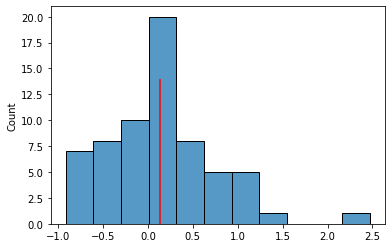

In [18]:
# grab posterior hippocampus (ROI 94)
%matplotlib inline
postHipp = con1_dat.extract_roi(mask=mask_bin[94])
postHippUvP = con2_dat.extract_roi(mask=mask_bin[94])
postHippP = con3_dat.extract_roi(mask=mask_bin[94])
postHippm = con4_dat.extract_roi(mask=mask_bin[94])
postHippUvC = con5_dat.extract_roi(mask=mask_bin[94])
sns.histplot(postHipp)
plt.vlines(x=np.mean(postHipp), ymin=0, ymax=14, color='red')
stats.ttest_1samp(postHippUvC, 0)

In [12]:
stats.ttest_rel(postHipp, postHippm)

Ttest_relResult(statistic=2.6380303877535694, pvalue=0.01045753437649105)

Ttest_1sampResult(statistic=-0.7684927278654917, pvalue=0.44502107466962704)

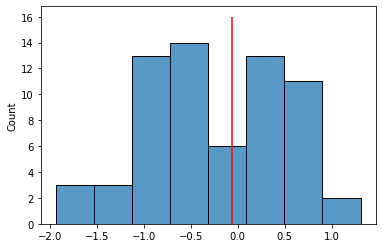

In [20]:
# test vmpfc
vmpfc = con1_dat.extract_roi(mask=mask_bin[42])
vmpfc_UvC = con5_dat.extract_roi(mask=mask_bin[42])
sns.histplot(vmpfc)
plt.vlines(x=np.mean(vmpfc_UvC), ymin=0, ymax=16, color='red')
stats.ttest_1samp(vmpfc_UvC, 0)

Ttest_1sampResult(statistic=3.016723077925202, pvalue=0.0036633832174539083)

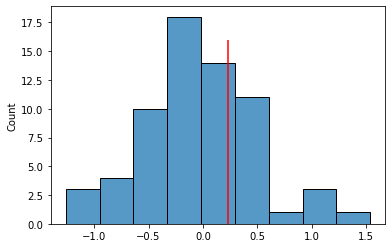

In [21]:
# anterior hippocampus
antHipp = con1_dat.extract_roi(mask=mask_bin[167])
antHippUvP = con2_dat.extract_roi(mask=mask_bin[167])
antHippP = con3_dat.extract_roi(mask=mask_bin[167])
antHippm = con4_dat.extract_roi(mask=mask_bin[167])
antHippUvC = con5_dat.extract_roi(mask=mask_bin[167])
sns.histplot(antHipp)
plt.vlines(x=np.mean(antHippUvC), ymin=0, ymax=16, color='red')
stats.ttest_1samp(antHippUvC, 0)

In [15]:
stats.ttest_rel(antHipp, antHippP)

Ttest_relResult(statistic=2.6804905356772095, pvalue=0.00933782010776972)

Ttest_1sampResult(statistic=-0.9608592750092598, pvalue=0.34023916254962705)

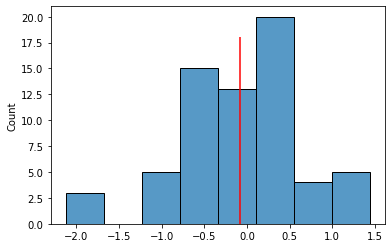

In [22]:
# control region (supramarginal left)
supra = con1_dat.extract_roi(mask=mask_bin[21])
supraUvC = con5_dat.extract_roi(mask=mask_bin[21])
sns.histplot(supraUvC)
plt.vlines(x=np.mean(supraUvC), ymin=0, ymax=18, color='red')
stats.ttest_1samp(supraUvC, 0)

In [ ]:
# combine all to dataset
d = pd.DataFrame({'postHipp': postHipp, 'vmpfc':vmpfc, 'antHipp':antHipp, 'supra':supra})
sns.pairplot(d)

In [ ]:
sns.catplot(x='variable', y='value', data=d.melt(), kind='bar')
plt.savefig('ppi_results.png')

## Plot differences between US and CS per region

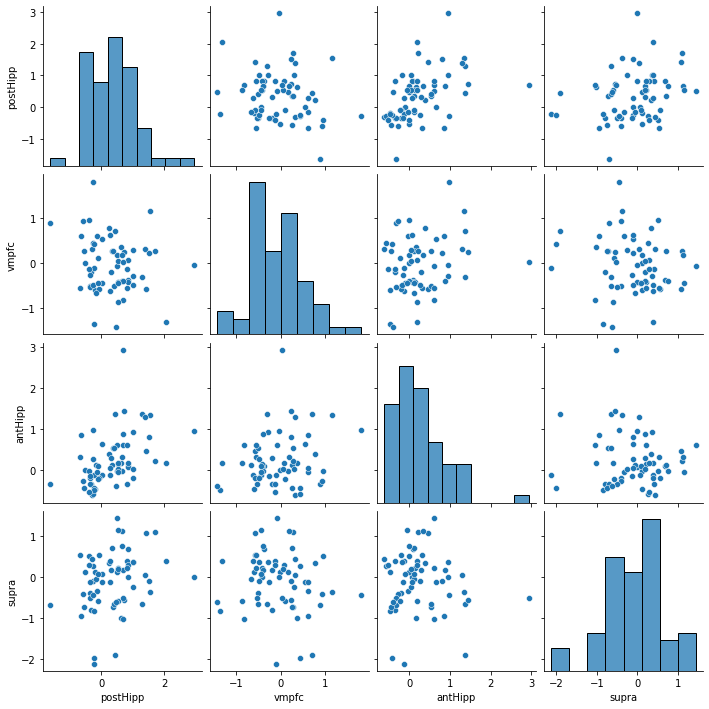

In [23]:
# combine all to dataset
d = pd.DataFrame({'postHipp': postHippUvC, 'vmpfc':vmpfc_UvC, 'antHipp':antHippUvC, 'supra':supraUvC})
sns.pairplot(d)

[<AxesSubplot:> <AxesSubplot:>]


/gpfs/ysm/project/joormann/oad4/conda_envs/naturalistic/lib/python3.7/site-packages/seaborn/categorical.py:3775: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try swarmplot
  warnings.warn(msg, UserWarning)


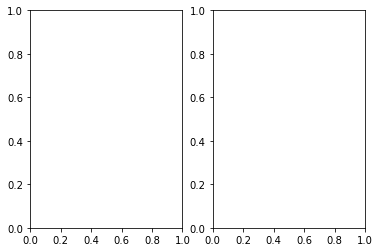

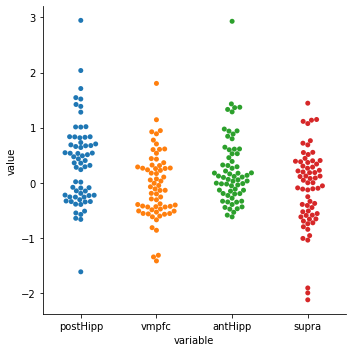

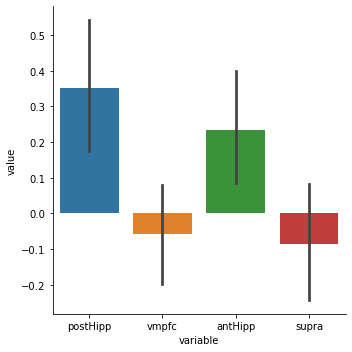

In [28]:
fig, axs = plt.subplots(1,2)
print(axs)
axs[0] = sns.catplot(x='variable', y='value', data=d.melt(), kind='swarm', ax=axs[0])
axs[1] = sns.catplot(x='variable', y='value', data=d.melt(), kind='bar')
plt.savefig('ppi_results_USvsCSperROI.png')

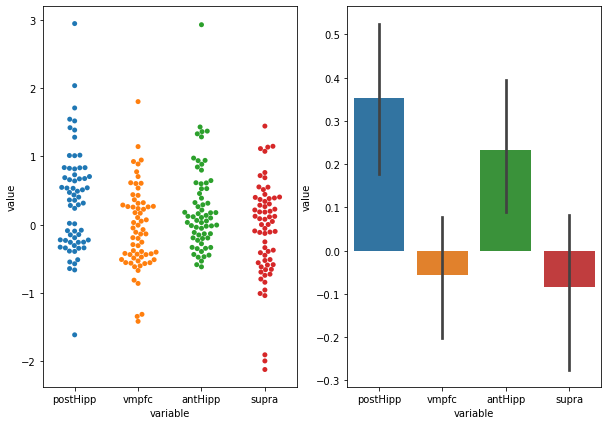

In [40]:
fig = plt.figure(figsize=(10,7))
gs = fig.add_gridspec(1,2)
axs = gs.subplots(sharey=False)
# print(gs)
sns.swarmplot(x='variable', y='value', data=d.melt(), ax=axs[0])
sns.barplot(x='variable', y='value', data=d.melt(), ax=axs[1])
plt.savefig('ppi_results_USvsCSperROI.png')